In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set(style="whitegrid")

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train.csv


In [ ]:
COLUMNS = [
    'Age',
    'Loan Amount Request (USD)',
    'Credit Score',
    'Property Age',
    'Co-Applicant',
    'Loan Sanction Amount (USD)'
]

data = pd.read_csv("train.csv", usecols=COLUMNS)

In [ ]:
# -------------------- DATA CLEANING --------------------
data.fillna({
    "Loan Amount Request (USD)": data["Loan Amount Request (USD)"].median(),
    "Credit Score": data["Credit Score"].median(),
    "Property Age": data["Property Age"].median(),
    "Co-Applicant": 0
}, inplace=True)

data = data.dropna(subset=['Loan Sanction Amount (USD)'])

# -------------------- FEATURES & TARGET --------------------
X = data.drop(columns=['Loan Sanction Amount (USD)'])
y = data['Loan Sanction Amount (USD)']

# -------------------- TRAIN TEST SPLIT --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# -------------------- MODELS --------------------
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(max_iter=10000, tol=1e-3),
    "ElasticNet": ElasticNet(max_iter=10000, tol=1e-3)
}

param_grids = {
    "Ridge": {"model__alpha": [0.01, 0.1, 1, 10]},
    "Lasso": {"model__alpha": [0.01, 0.1, 1, 10]},   # removed 0.001 (too slow)
    "ElasticNet": {
        "model__alpha": [0.01, 0.1, 1],
        "model__l1_ratio": [0.3, 0.5, 0.7]
    }
}



In [ ]:
coefficients = {}
best_cv_r2 = {}
test_results = {}

for name, model in models.items():

    print(f"\nTraining {name} model...")

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    if name == "Linear":
        best_model = pipe.fit(X_train, y_train)
        best_cv_r2[name] = None
    else:
        grid = GridSearchCV(
            pipe,
            param_grids[name],
            cv=5,
            scoring="r2",
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_cv_r2[name] = grid.best_score_

    # ---- Test Set Performance ----
    y_test_pred = best_model.predict(X_test)

    test_results[name] = {
        "MAE": mean_absolute_error(y_test, y_test_pred),
        "MSE": mean_squared_error(y_test, y_test_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "R2": r2_score(y_test, y_test_pred)
    }

    # ---- STORE COEFFICIENTS (THIS WAS MISSING) ----
    coefficients[name] = best_model.named_steps["model"].coef_



Training Linear model...

Training Ridge model...

Training Lasso model...

Training ElasticNet model...


In [ ]:
# -------------------- CROSS VALIDATION PERFORMANCE --------------------
cv_results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    cv_mae = -cross_val_score(
        pipe, X, y, cv=5, scoring="neg_mean_absolute_error"
    ).mean()

    cv_mse = -cross_val_score(
        pipe, X, y, cv=5, scoring="neg_mean_squared_error"
    ).mean()

    cv_r2 = cross_val_score(
        pipe, X, y, cv=5, scoring="r2"
    ).mean()

    cv_results[name] = {
        "MAE": cv_mae,
        "MSE": cv_mse,
        "RMSE": np.sqrt(cv_mse),
        "R2": cv_r2
    }

cv_df = pd.DataFrame(cv_results).T
print("\n5-FOLD CROSS VALIDATION PERFORMANCE")
print(cv_df)



5-FOLD CROSS VALIDATION PERFORMANCE
                     MAE           MSE          RMSE        R2
Linear      21591.357431  9.719288e+08  31175.773166  0.581558
Ridge       21591.521602  9.719147e+08  31175.545794  0.581564
Lasso       21591.400820  9.718972e+08  31175.266425  0.581572
ElasticNet  24596.322422  1.276290e+09  35725.195571  0.451351


In [ ]:
test_df = pd.DataFrame(test_results).T
print("\nTEST SET PERFORMANCE")
print(test_df)



TEST SET PERFORMANCE
                     MAE           MSE          RMSE        R2
Linear      21576.678250  1.015866e+09  31872.650492  0.552438
Ridge       21578.155947  1.015808e+09  31871.736683  0.552463
Lasso       21577.569601  1.015825e+09  31872.003683  0.552456
ElasticNet  21767.135546  1.011911e+09  31810.547246  0.554180



COEFFICIENT COMPARISON TABLE
                               Linear       Ridge       Lasso  ElasticNet
Age                         -794.1761   -793.6947   -782.9122   -739.0661
Loan Amount Request (USD)  33353.7267  33340.1199  33346.2866  31815.3912
Credit Score               11736.2923  11733.6433  11726.1903  11424.5346
Property Age                  44.7326     45.3012     35.2365    105.9557
Co-Applicant                -522.1028   -521.9097   -512.0828   -499.9971


<Figure size 1200x600 with 0 Axes>

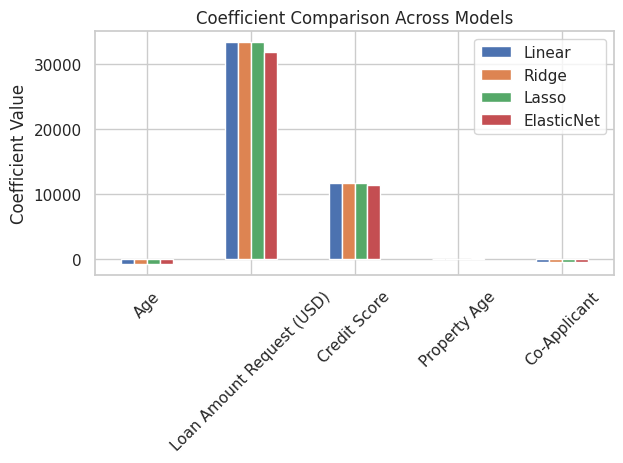

In [ ]:
coef_df = pd.DataFrame(
    coefficients,
    index=X.columns
).round(4)

print("\nCOEFFICIENT COMPARISON TABLE")
print(coef_df)

# Bar plot
plt.figure(figsize=(12,6))
coef_df.plot(kind="bar")
plt.title("Coefficient Comparison Across Models")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


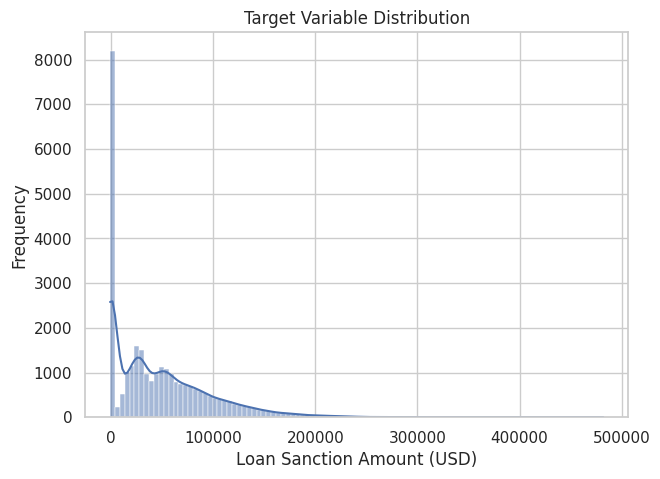

In [ ]:
plt.figure(figsize=(7,5))
sns.histplot(y, kde=True)
plt.title("Target Variable Distribution")
plt.xlabel("Loan Sanction Amount (USD)")
plt.ylabel("Frequency")
plt.show()


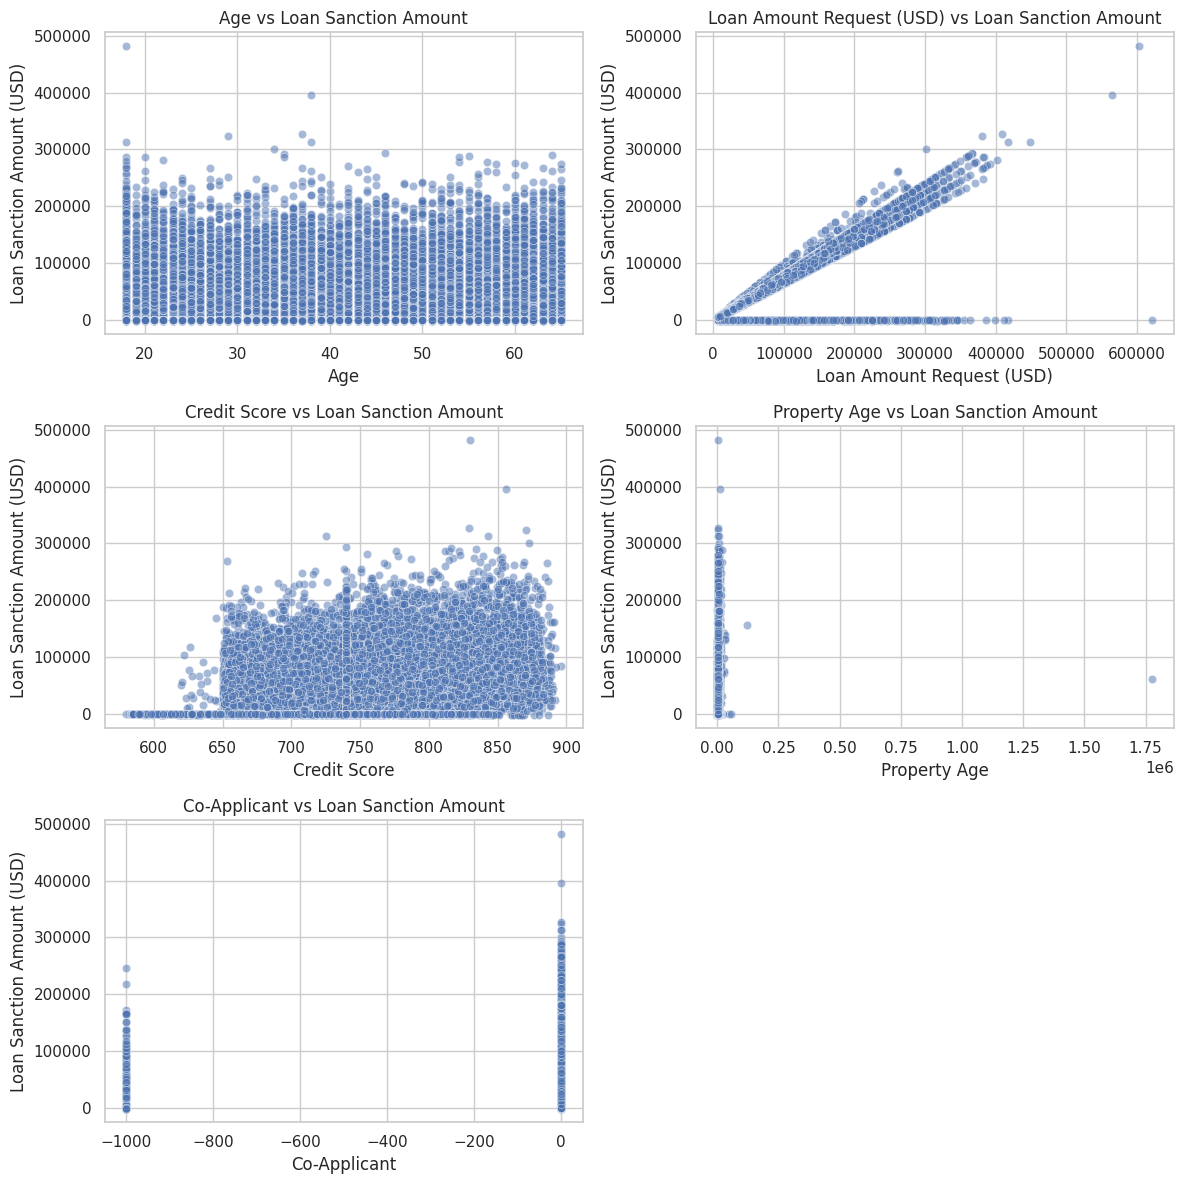

In [ ]:
import math

n = len(X.columns)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    ax = axes[i]
    sns.scatterplot(x=X[col], y=y, alpha=0.5, ax=ax)
    ax.set_title(f"{col} vs Loan Sanction Amount")
    ax.set_xlabel(col)
    ax.set_ylabel("Loan Sanction Amount (USD)")

# remove empty plots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


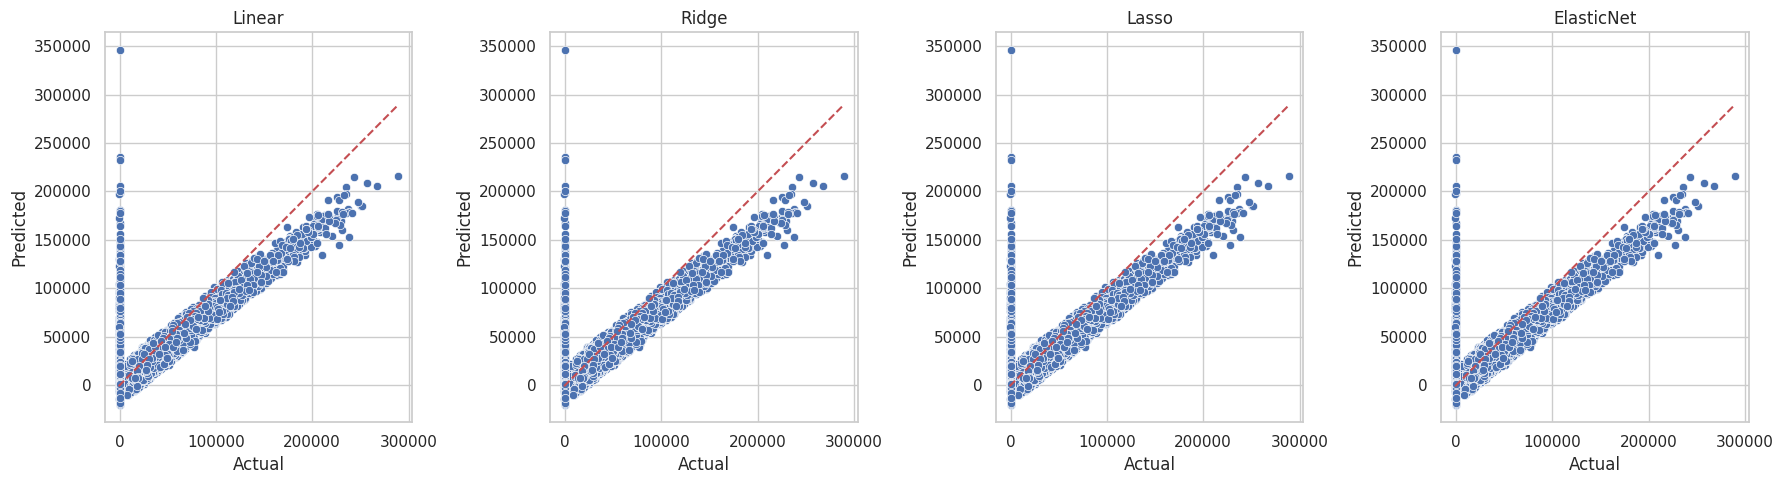

In [ ]:
fig, axes = plt.subplots(1, len(models), figsize=(18,5))

for i, name in enumerate(models.keys()):
    model = models[name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    ax = axes[i]
    sns.scatterplot(x=y_test, y=y_pred, ax=ax)
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()], "r--")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(f"{name}")

plt.tight_layout()
plt.show()


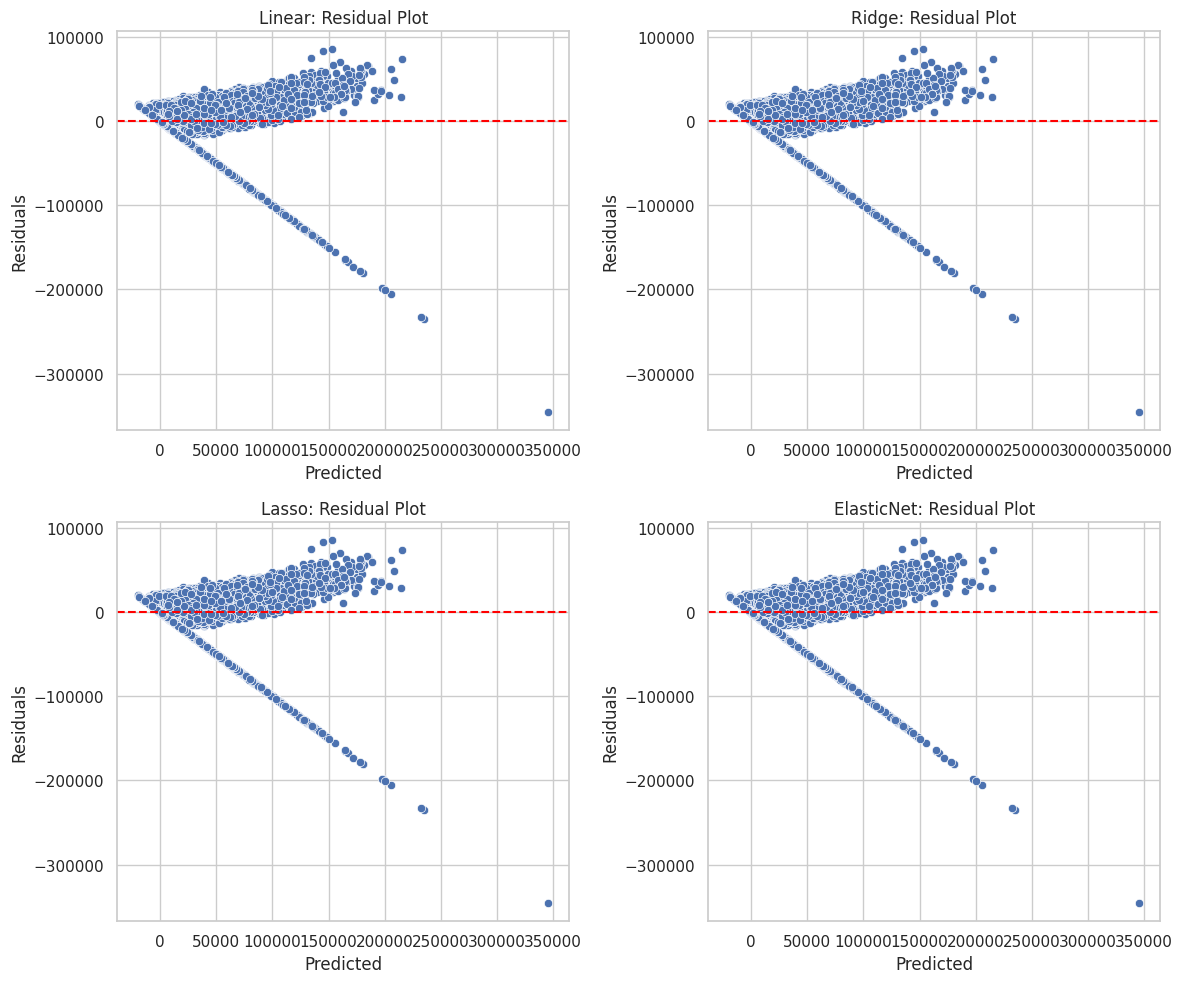

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

for i, name in enumerate(models.keys()):
    model = models[name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    ax = axes[i]
    sns.scatterplot(x=y_pred, y=residuals, ax=ax)
    ax.axhline(0, color="red", linestyle="--")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title(f"{name}: Residual Plot")

plt.tight_layout()
plt.show()
